In [8]:
!pip freeze | grep scikit

scikit-image==0.25.2
scikit-learn==1.6.1


In [9]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/doan_demo'

In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [11]:
# Đọc dữ liệu
df = pd.read_csv('x_ray_and_features_data.csv')

# Danh sách bệnh (các cột label trong df)
diseases = [
    'pneumonia', 'tuberculosis', 'bronchitis', 'arthritis',
    'fracture', 'lung_cancer', 'scoliosis', 'lung_infection'
]

# MIMIC-IV features (clinical / lab / vital signs)
mimic_feats = [
    'diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature',
    'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough'
]

# Image features: giả sử cột tên '0' tới '17'
img_feats = [str(x) for x in range(18)]

# Dataset feature tổng hợp
data = df[img_feats + mimic_feats]

print("Data shape:", data.shape)
print("Example columns:", data.columns.tolist()[:20])


Data shape: (29083, 29)
Example columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', 'diabete', 'age']


In [12]:
def gaussian_augment_minority(x_train: pd.DataFrame,
                              y_train: pd.Series,
                              img_feats,
                              minority_class: int = 1,
                              target_ratio: float = 1.0,
                              noise_scale: float = 0.05,
                              random_state: int = 42):
    """
    Data augmentation bằng Gaussian noise trên image features cho lớp thiểu số.

    Params
    ------
    - x_train: DataFrame train (chứa cả image + MIMIC)
    - y_train: Series label train
    - img_feats: list tên cột image features (vd: ['0','1',...])
    - minority_class: class được coi là thiểu số để augment (thường là 1)
    - target_ratio: tỉ lệ size(minority) / size(majority) sau augment.
        = 1.0 nghĩa là cân bằng.
    - noise_scale: hệ số nhân cho std khi tạo noise (0.05–0.2 thường hợp lý)
    - random_state: seed

    Return
    ------
    - x_out, y_out: dữ liệu sau khi augment.
    """
    rng = np.random.default_rng(random_state)

    class_counts = y_train.value_counts()
    if minority_class not in class_counts.index:
        # Không có minority_class trong train => không augment được
        return x_train.copy(), y_train.copy()

    n_min = class_counts[minority_class]
    # majority = class còn lại (giả sử nhị phân)
    maj_class = class_counts.index[class_counts.index != minority_class][0]
    n_maj = class_counts[maj_class]

    # Số mẫu minority mong muốn sau augment
    n_target_min = int(target_ratio * n_maj)
    n_to_generate = max(0, n_target_min - n_min)
    if n_to_generate == 0:
        # Đã cân bằng hoặc minority >= target => không cần augment
        return x_train.copy(), y_train.copy()

    # Lấy các hàng minority
    idx_min = np.where(y_train == minority_class)[0]
    # Sample với lặp lại
    sampled_idx = rng.choice(idx_min, size=n_to_generate, replace=True)

    x_min_img = x_train.iloc[sampled_idx][img_feats].to_numpy()

    # Tính std cho từng feature ảnh
    img_std = x_train[img_feats].to_numpy().std(axis=0) + 1e-6
    noise = rng.normal(
        loc=0.0,
        scale=noise_scale * img_std,
        size=x_min_img.shape
    )

    x_aug_img = x_min_img + noise

    # Tạo bản sao đầy đủ (cả MIMIC) cho các mẫu synthetic
    x_synth = x_train.iloc[sampled_idx].copy()
    x_synth.loc[:, img_feats] = x_aug_img

    # Gộp lại
    x_out = pd.concat([x_train, x_synth], ignore_index=True)
    y_out = pd.concat(
        [y_train, pd.Series([minority_class] * n_to_generate)],
        ignore_index=True
    )

    return x_out, y_out


In [13]:
from typing import Callable

def classify_and_compare_GAUSS(
        clf_factory: Callable,
        d,
        l,
        test: float = 0.35,
        verbose: int = 0,
        print_res: bool = False,
        df=None,
        engineering: str = 'GaussianNoise',
        disease: str = 'None',
        noise_scale: float = 0.05,
        target_ratio: float = 1.0):
    r'''
    So sánh mô hình với và không có MIMIC-IV,
    sử dụng data augmentation Gaussian Noise trên image features cho lớp thiểu số.

    Params
    ------
    - clf_factory: hàm tạo classifier, kiểu sklearn (vd: make_rf)
    - d: dataset chứa cả MIMIC-IV và image features
    - l: label
    - test: test split ratio
    - print_res: nếu True thì in report, nếu False thì ghi vào df
    - df: DataFrame để append kết quả
    - engineering: tag mô tả kỹ thuật xử lý (vd: 'GaussianNoise')
    - disease: tên bệnh
    - noise_scale: độ lớn Gaussian noise
    - target_ratio: tỉ lệ mong muốn minority/majority sau augment
    '''

    # 1. Split train/test
    xtr, xte, ytr, yte = train_test_split(
        d, l, test_size=test, stratify=l, random_state=None
    )
    xtr = xtr.reset_index(drop=True)
    ytr = ytr.reset_index(drop=True)

    # 2. Augment Gaussian Noise cho minority class (giả sử bệnh = 1)
    xtr_aug, ytr_aug = gaussian_augment_minority(
        x_train=xtr,
        y_train=ytr,
        img_feats=img_feats,
        minority_class=1,
        target_ratio=target_ratio,
        noise_scale=noise_scale,
        random_state=42
    )

    # 3. Train/eval 3 case

    # c1: Model chính với tất cả features (image + MIMIC)
    clf_e = clf_factory()
    clf_e.fit(xtr_aug, ytr_aug)
    p_e = clf_e.predict(xte)
    c1 = classification_report(yte, p_e, output_dict=not print_res)

    # c2: Model chính chỉ với image features
    clf_o = clf_factory()
    clf_o.fit(xtr_aug[img_feats], ytr_aug)
    p_o = clf_o.predict(xte[img_feats])
    c2 = classification_report(yte, p_o, output_dict=not print_res)

    # c3: Baseline LogisticRegression chỉ với image features
    base_clf = LogisticRegression(max_iter=1000)
    base_clf.fit(xtr_aug[img_feats], ytr_aug)
    p_L = base_clf.predict(xte[img_feats])
    c3 = classification_report(yte, p_L, output_dict=not print_res)

    if print_res:
        print("=== Enhanced (image + MIMIC, RF) ===")
        print(c1)
        print("\n=== Original (image only, RF) ===")
        print(c2)
        print("\n=== Baseline (image only, Logistic) ===")
        print(c3)
        return

    # 4. Nếu không print, lưu kết quả vào df
    col = pd.Series({
        'Model': clf_factory.__name__,
        'Engineering': engineering,
        'Disease': disease,
        # Accuracy
        'acc_e': c1['accuracy'],
        'acc_o': c2['accuracy'],
        'acc_d': c1['accuracy'] - c2['accuracy'],   # E - O (hiệu ứng MIMIC)
        'acc_i': c2['accuracy'] - c3['accuracy'],   # O - L (hiệu ứng transfer)
        'acc_x': c1['accuracy'] - c3['accuracy'],   # E - L (tổng hợp)
        # Precision negative class (0)
        'p0_e': c1['0']['precision'],
        'p0_o': c2['0']['precision'],
        'p0_d': c1['0']['precision'] - c2['0']['precision'],
        # Precision positive class (1)
        'p1_e': c1['1']['precision'],
        'p1_o': c2['1']['precision'],
        'p1_d': c1['1']['precision'] - c2['1']['precision'],   # MIMIC effect
        'p1_i': c2['1']['precision'] - c3['1']['precision'],   # transfer effect
        'p1_x': c1['1']['precision'] - c3['1']['precision'],   # combined
        # Recall negative
        'r0_e': c1['0']['recall'],
        'r0_o': c2['0']['recall'],
        'r0_d': c1['0']['recall'] - c2['0']['recall'],
        # Recall positive
        'r1_e': c1['1']['recall'],
        'r1_o': c2['1']['recall'],
        'r1_d': c1['1']['recall'] - c2['1']['recall'],         # MIMIC effect
        'r1_i': c2['1']['recall'] - c3['1']['recall'],         # transfer effect
        'r1_x': c1['1']['recall'] - c3['1']['recall'],         # combined
    })

    df[len(df.columns)] = col


In [14]:
# Hàm tạo RandomForest (model chính)
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )

models = [make_rf]

# Số lần lặp mỗi bệnh mỗi model
n_iter = 5
test_size = 0.35
res = pd.DataFrame()

for d_name in tqdm.tqdm(diseases):
    l = df[d_name]
    for m in models:
        for i in range(n_iter):
            classify_and_compare_GAUSS(
                clf_factory=m,
                d=data,
                l=l,
                test=test_size,
                df=res,
                engineering='GaussianNoise',
                disease=d_name,
                noise_scale=0.05,     # bạn có thể tune
                target_ratio=1.0     # cân bằng minority/majority
            )

res_T = res.T
res_T.head()


100%|██████████| 8/8 [1:20:55<00:00, 606.88s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,acc_i,acc_x,p0_e,p0_o,...,p1_i,p1_x,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d,r1_i,r1_x
0,make_rf,GaussianNoise,pneumonia,0.770923,0.722986,0.047937,0.170334,0.218271,0.773037,0.727781,...,0.088407,0.425232,0.968729,0.987681,-0.018952,0.247762,0.022914,0.224848,-0.559971,-0.335124
1,make_rf,GaussianNoise,pneumonia,0.766601,0.721906,0.044695,0.167191,0.211886,0.76996,0.727119,...,0.046986,0.405577,0.967375,0.987275,-0.0199,0.235589,0.02005,0.215539,-0.565342,-0.349803
2,make_rf,GaussianNoise,pneumonia,0.76778,0.72279,0.04499,0.163949,0.208939,0.771367,0.727863,...,0.083534,0.404383,0.966428,0.987004,-0.020577,0.242392,0.023989,0.218403,-0.553169,-0.334765
3,make_rf,GaussianNoise,pneumonia,0.772397,0.723379,0.049018,0.179077,0.228094,0.772171,0.728071,...,0.107665,0.454819,0.973602,0.987681,-0.014079,0.240243,0.024347,0.215897,-0.563194,-0.347297
4,make_rf,GaussianNoise,pneumonia,0.772004,0.721513,0.050491,0.176523,0.227014,0.773542,0.726378,...,0.011773,0.434961,0.969676,0.988629,-0.018952,0.249194,0.015038,0.234157,-0.578231,-0.344074


In [15]:
# Kết quả chi tiết (mỗi hàng = 1 lần run)
results = res.T

# Lưu toàn bộ kết quả
results.to_csv('results_gaussian_all_runs.csv', index=False)

# Mean theo Model, Engineering, Disease
rmean = results.groupby(['Model', 'Engineering', 'Disease']).mean()
rmean.to_csv('results_gaussian_mean.csv')

# Standard deviation
rsd = results.groupby(['Model', 'Engineering', 'Disease']).std()
rsd.to_csv('results_gaussian_std.csv')

# Bảng mean ± std
res_agg = rmean.combine(
    rsd,
    lambda x1, x2: x1.apply(lambda x: round(x, 3)).astype(str)
                  + '±' +
                  x2.apply(lambda x: round(x, 3)).astype(str)
)
res_agg.to_csv('results_gaussian_agg.csv')

print(rmean.head().to_markdown())
print("Metric columns:", rmean.columns.tolist())


|                                                |    acc_e |    acc_o |       acc_d |    acc_i |    acc_x |     p0_e |     p0_o |        p0_d |     p1_e |     p1_o |     p1_d |       p1_i |     p1_x |     r0_e |     r0_o |         r0_d |      r1_e |      r1_o |      r1_d |      r1_i |      r1_x |
|:-----------------------------------------------|---------:|---------:|------------:|---------:|---------:|---------:|---------:|------------:|---------:|---------:|---------:|-----------:|---------:|---------:|---------:|-------------:|----------:|----------:|----------:|----------:|----------:|
| ('make_rf', 'GaussianNoise', 'arthritis')      | 0.959273 | 0.959037 | 0.000235756 | 0.442161 | 0.442397 | 0.959263 | 0.959037 | 0.000226162 | 1        | 0        | 1        | -0.0487003 | 0.9513   | 1        | 1        |  0           | 0.0057554 | 0         | 0.0057554 | -0.583213 | -0.577458 |
| ('make_rf', 'GaussianNoise', 'bronchitis')     | 0.950334 | 0.948919 | 0.00141454  | 0.351591 | 0.353

In [16]:
def mdl_fmt(text: str) -> str:
    # Nếu index là chuỗi dạng "('Model','Engineering','Disease')" thì làm gọn lại
    return text.replace("('", "").replace("')", "").replace("', '", " | ")


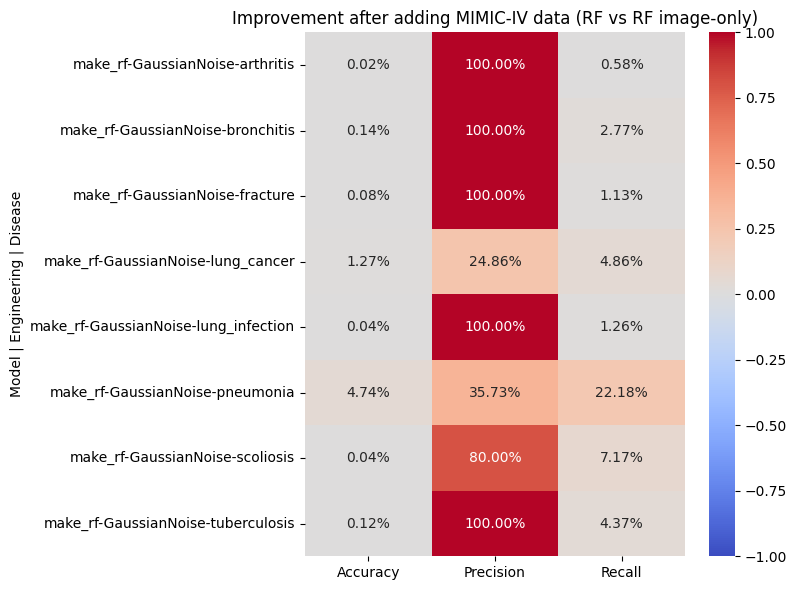

In [17]:
diffs = ['acc_d', 'p1_d', 'r1_d']
data_diff = rmean[diffs].apply(pd.to_numeric, errors='coerce')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    data_diff,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2%",
    ax=ax
)

ax.set_title('Improvement after adding MIMIC-IV data (RF vs RF image-only)')
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(t.get_text()) for t in ax.get_yticklabels()])
ax.set_ylabel('Model | Engineering | Disease')

plt.tight_layout()
plt.show()


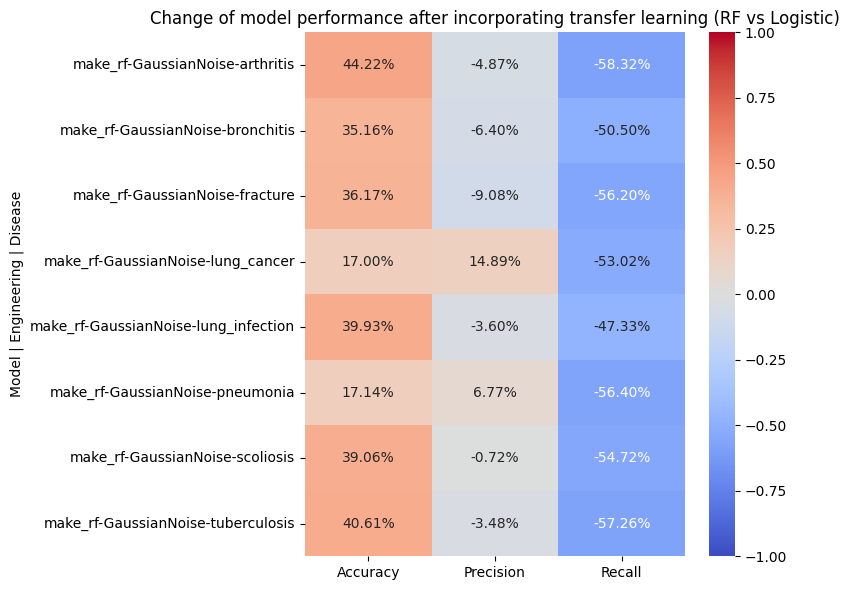

In [18]:
diffs = ['acc_i', 'p1_i', 'r1_i']
data_diff = rmean[diffs].apply(pd.to_numeric, errors='coerce')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    data_diff,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2%",
    ax=ax
)

ax.set_title('Change of model performance after incorporating transfer learning (RF vs Logistic)')
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(t.get_text()) for t in ax.get_yticklabels()])
ax.set_ylabel('Model | Engineering | Disease')

plt.tight_layout()
plt.show()


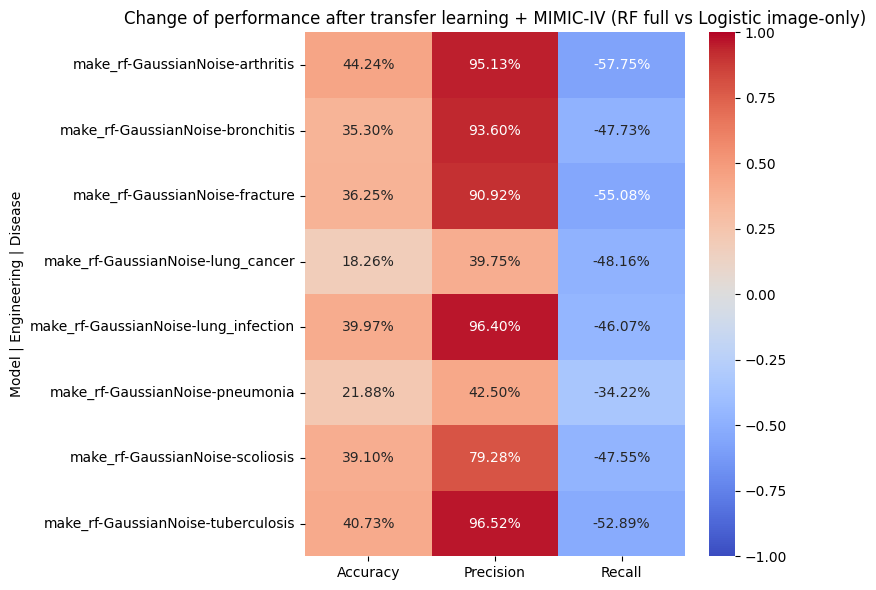

In [19]:
diffs = ['acc_x', 'p1_x', 'r1_x']
data_diff = rmean[diffs].apply(pd.to_numeric, errors='coerce')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    data_diff,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2%",
    ax=ax
)

ax.set_title('Change of performance after transfer learning + MIMIC-IV (RF full vs Logistic image-only)')
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
ax.set_yticklabels([mdl_fmt(t.get_text()) for t in ax.get_yticklabels()])
ax.set_ylabel('Model | Engineering | Disease')

plt.tight_layout()
plt.show()


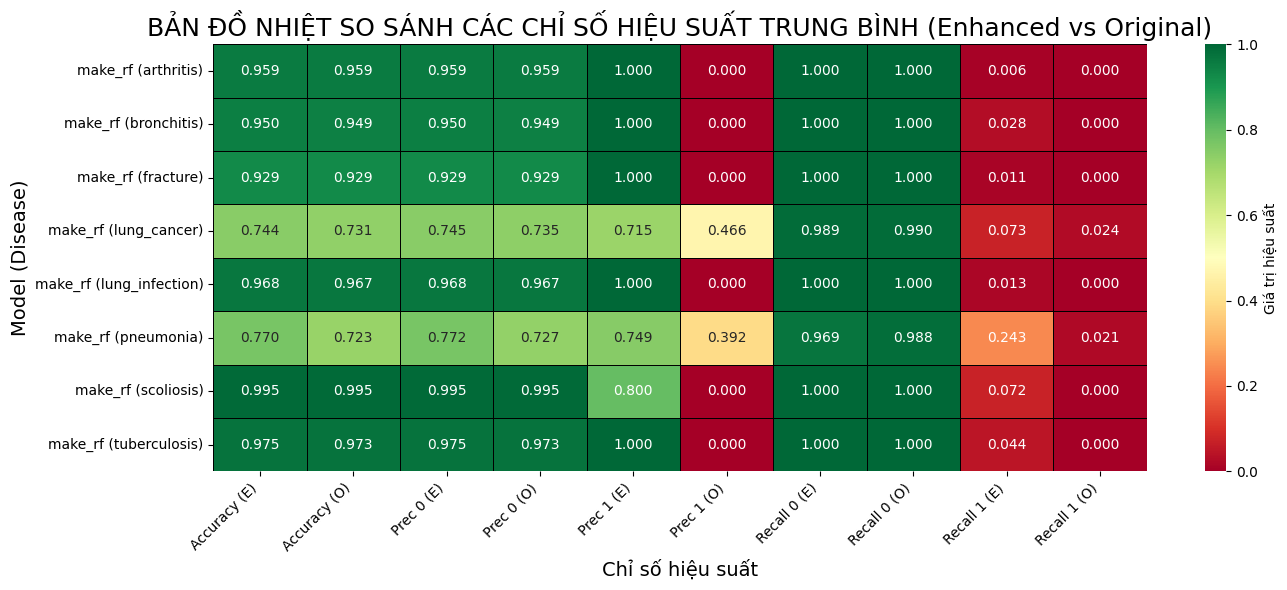

In [20]:
import io

# chọn các metric muốn vẽ
metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
]

# tạo cột hiển thị Model + Disease trên trục Y
heatmap_df = rmean.reset_index()
heatmap_df['Model_Disease'] = heatmap_df['Model'] + ' (' + heatmap_df['Disease'] + ')'

# lấy đúng các cột cần vẽ
heatmap_df = heatmap_df.set_index('Model_Disease')[metrics_to_plot]

# đổi tên cột cho dễ đọc
new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec 0 (E)',    'p0_o': 'Prec 0 (O)',
    'p1_e': 'Prec 1 (E)',    'p1_o': 'Prec 1 (O)',
    'r0_e': 'Recall 0 (E)',  'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)',  'r1_o': 'Recall 1 (O)',
}
heatmap_df = heatmap_df.rename(columns=new_col_names)

# ép kiểu float cho chắc chắn
heatmap_df = heatmap_df.astype(float)

# vẽ heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Giá trị hiệu suất'}
)

plt.title('BẢN ĐỒ NHIỆT SO SÁNH CÁC CHỈ SỐ HIỆU SUẤT TRUNG BÌNH (Enhanced vs Original)', fontsize=18)
plt.xlabel('Chỉ số hiệu suất', fontsize=14)
plt.ylabel('Model (Disease)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
